# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.05           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# time series
t_start = 0.0
t_end = 4000.0
time_samples = 2000
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = 0.5     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t,A,P):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta + (A * np.sin((2*mt.pi*t)/P))
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

# Variance in peak cross-correlation

In order to quantify to variance in peak cross-correlation, we run an experiment where a distribution of initial conditions is considered. 

In [3]:
import sdeint
import math as mt

# solve the system of ODEs with a sample set of initial conditions
samples = 100
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr_s = []; peak_corr_p1 = []; peak_corr_sp1 = []; peak_corr_p2 = []; peak_corr_sp2 = []; peak_corr_p3 = []; peak_corr_sp3 = []
To_l = []; Ta_l = []

# redefine periodically forced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc0(x, t):
    return C.dot(x) + np.array([0.0,(A * np.sin((2*mt.pi*t)/P))])

def unforc1(x, t):
    return C.dot(x)

# define forcing function (weiner process with <cross-section>)
#scaleS = [0.00, 0.0025, 0.005, 0.0075, 0.010, 0.015]
scaleS = [0.000, 0.005, 0.010, 0.015, 0.020, 0.025, 0.050, 0.100]
scaleP = [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]
#scaleS = [0.00, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20, 0.50, 1.00, 5.00, 10.00, 100.00] 
Period = [10.0, 20.0, 30.0]
Period = [2*mt.pi*k for k in Period]

def forc2(x, t):
    return W2

for j,k in zip(scaleS, scaleP):
    crosssec = j * Tai
    A = k * crosssec                             #rel. amp. of periodic
    peak_corr1_20 = []; peak_corr2_20 = []; peak_corr1_40 = []; peak_corr2_40 = []; peak_corr1_60 = []; peak_corr2_60 = []; peak_corr0 = []
    for i in range(samples):
        x0 = [rand.uniform(0.0, Toi_lim), rand.uniform(0.0, Tai_lim)]

        #stochastically forced
        W2 = np.diag([0.0, crosssec])
        soln = sdeint.itoint(unforc1,forc2,x0,t) #stoch
        To_t = soln[:,0]; To_l.append(To_t)      #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)      #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr0.append(abs(lag_time[max_index]))
        
        #periodically forced
        P = Period[0]
        soln = odeint(f,x0,t,args=(crosssec,P))   #periodic
        To_t = soln[:,0]; To_l.append(To_t)       #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)       #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr1_20.append(abs(lag_time[max_index]))
        
        #stochastically + periodically forced
        soln = sdeint.itoint(unforc0,forc2,x0,t)       #stoch + periodic
        
        To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr2_20.append(abs(lag_time[max_index]))
        
        #periodically forced
        P = Period[1]
        soln = odeint(f,x0,t,args=(crosssec,P))   #periodic
        To_t = soln[:,0]; To_l.append(To_t)       #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)       #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr1_40.append(abs(lag_time[max_index]))
        
        #stochastically + periodically forced
        soln = sdeint.itoint(unforc0,forc2,x0,t)       #stoch + periodic
        
        To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr2_40.append(abs(lag_time[max_index]))
        
        #periodically forced
        P = Period[2]
        soln = odeint(f,x0,t,args=(crosssec,P))   #periodic
        To_t = soln[:,0]; To_l.append(To_t)       #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)       #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr1_60.append(abs(lag_time[max_index]))
        
        #stochastically + periodically forced
        soln = sdeint.itoint(unforc0,forc2,x0,t)       #stoch + periodic
        
        To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr2_60.append(abs(lag_time[max_index]))
    
    peak_corr_s.append(peak_corr0)
    peak_corr_p1.append(peak_corr1_20)
    peak_corr_sp1.append(peak_corr2_20)
    peak_corr_p2.append(peak_corr1_40)
    peak_corr_sp2.append(peak_corr2_40)
    peak_corr_p3.append(peak_corr1_60)
    peak_corr_sp3.append(peak_corr2_60)
    
CorrL = [peak_corr_s,peak_corr_p1,peak_corr_sp1,peak_corr_p2,peak_corr_sp2,peak_corr_p3,peak_corr_sp3]

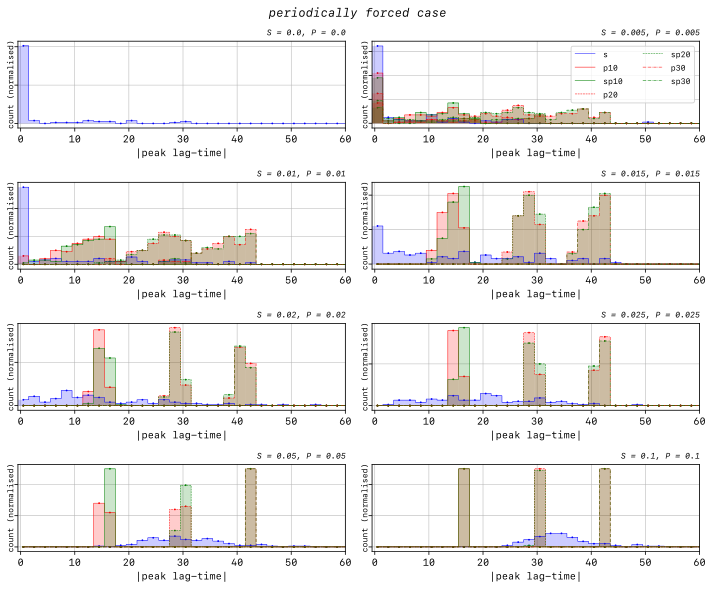

In [125]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from scipy.optimize.minpack import curve_fit
%config InlineBackend.figure_format = 'svg'
       
# plot cross-corr statistics vs lag-times
binwidth = 2; bin_off = 0.5;
bins = np.arange(0 - bin_off, 60 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2

cols = int(mt.sqrt(len(scaleS)))
rows = int(len(scaleS)/cols)

if len(scaleS)%cols != 0:
    rows = rows + 1

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10,8), dpi=100)
i = 0

for row in ax:
    for col in row:
        if i == len(scaleS):
            col.axis('off')
            continue  
        
        if i in []:
            linewidth = 0.0
        else:
            linewidth = 0.5
        
        ln   = ['-','-','-','--','--','-.','-.']
        fc   = ['b','r','g','r','g','r','g']
        locs = ['upper right', 'upper right', 'upper right', 'upper right', 'upper right', 'upper right', 'upper right']
        lg   = ['s','p10','sp10','p20','sp20','p30','sp30']
        
        for k, j in enumerate(CorrL):
            counts = np.histogram(np.abs(j[i]), bins = bins, density=True)[0]
            if i in []:   
                counts1 = [np.min(counts[np.nonzero(counts)]) if x == 0 else x for x in counts]
            else:
                counts1 = counts
                
            if i in [0] and k > 0:
                continue
            else:
                col.scatter(binp, counts1, marker='.', c=fc[k], s = 3.0)
                col.bar(binp, counts1, align='center', facecolor=fc[k], alpha=0.2, width=binwidth)
                col.step(binp, counts1, fc[k], linewidth=linewidth, where='mid', linestyle=ln[k])
                #col.fill_between(binp, counts1, alpha=0.1, facecolor=fc[k])
                
            ticks(col,10); col.grid(linewidth=0.5);  col.set_axisbelow(True); plt.setp(col.get_yticklabels(), visible=False)
            col.set_title('S = ' + str(scaleS[i]) + ', P = ' + str(scaleS[i]*scaleP[i]),fontproperties=fontit,fontsize=8, loc='right'); 
            col.yaxis.set_major_formatter(FormatStrFormatter('%.2f')); col.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
            col.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=10);
        
            if i in []:
                col.set_yscale('log'); col.set_ylabel('log(count) (normalised)',fontproperties=font,fontsize=8);
                col.yaxis.set_label_coords(-0.015,0.45)   
            else:
                col.set_ylabel('count (normalised)',fontproperties=font,fontsize=8);
                col.yaxis.set_label_coords(-0.01,0.50)
            
            if i in [1]:
                l1 = col.legend(lg, loc=locs[k], ncol=2)
                plt.setp(l1.texts, family='SF Mono', fontsize=8)
            
            col.set_xlim([-0.5,60.0])
        i = i + 1
        
fig.tight_layout()
fig.suptitle('periodically forced case',fontproperties=fontit,fontsize=12,y=1.02);

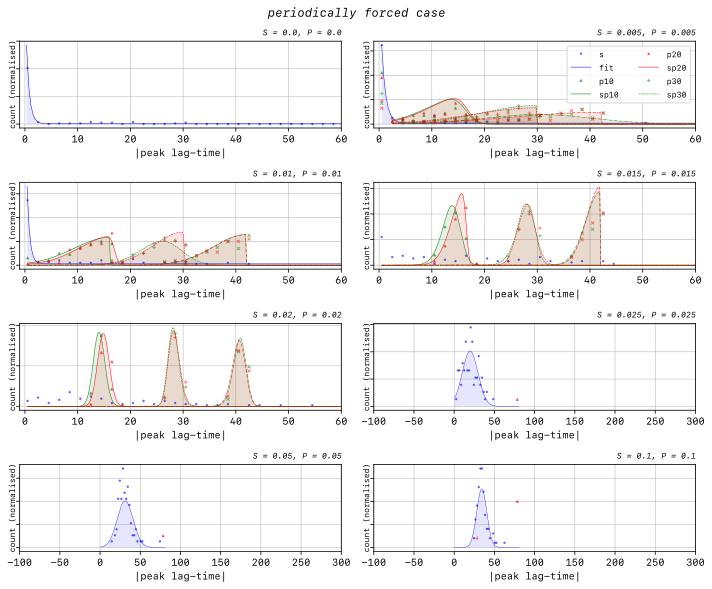

In [90]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import scipy as sp
from scipy.optimize.minpack import curve_fit
%config InlineBackend.figure_format = 'svg'

def exp_fit(x, y, guess, b):
    smoothx = np.linspace(x[0]-b, x[-1], 200); 
    exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0
    params, cov = curve_fit(exp_decay, x, y, p0=guess)
    A, t, y0 = params
    best_fit = lambda x: A * np.exp(t * x) + y0
    return smoothx, best_fit

def skewnorm_fit(x,y):
    ae, loce, scalee = stats.skewnorm.fit(y)
    smoothx = np.linspace(x[0], x[-1], 500)
    best_fit = stats.skewnorm.pdf(smoothx,ae,loce,scalee)
    return smoothx, best_fit

def norm_fit(x,y,c):
    y = [i for i in y if float(i) <= c]
    mu, std = stats.norm.fit(y)
    smoothx = np.linspace(x[0], x[-1], 500)
    best_fit = stats.norm.pdf(smoothx, mu, std)
    return smoothx, best_fit

       
# plot cross-corr statistics vs lag-times
binwidth = 2; bin_off = 0.5;
bins = np.arange(0 - bin_off, 80 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2

cols = int(mt.sqrt(len(scaleS)))
rows = int(len(scaleS)/cols)

if len(scaleS)%cols != 0:
    rows = rows + 1

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10,8), dpi=100)
i = 0

for row in ax:
    for col in row:
        if i == len(scaleS):
            col.axis('off')
            break
        #stoch only 
        offset = 1  
        
        mark = ['.b-','^g-','^r-','+g-','+r-','xg-','xr-']
        colr = ['b-','g-','r-','g-','r-','g-','r-']
        colx = ['b-','g-','r-','g--','r--','g-.','r-.']
        fc   = ['b','g','r','g','r','g','r']
        locs = ['upper right', 'upper right', 'upper right', 'upper right', 'upper right', 'upper right', 'upper right']
        lg   = ['s','fit','p10','sp10','p20','sp20','p30','sp30']
        size = [3.0, 2.0, 2.0, 3.5, 3.5, 3.0, 3.0]
        linewidth = 0.0
        breakit      = [['NaN', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],['NaN', 3.0, 3.0, 3.0, 3.0, 3.0, 3.0],[],[],[],[]]
        buffer = 1.0
        guess = [0.99,-2,0.01]
        filter_norm = 100.0
        
        for k, j in enumerate([peak_corr_s, peak_corr_p1, peak_corr_sp1, peak_corr_p2, peak_corr_sp2, peak_corr_p3, peak_corr_sp3]):           
            counts = np.histogram(np.abs(j[i]), bins = bins, density=True)[0]
            if i in []:   
                counts1 = [np.min(counts[np.nonzero(counts)]) if x == 0 else x for x in counts]
            elif i in [0]:
                counts1 = counts
            else:
                counts1= [float('nan') if x == 0 else x for x in counts]
            
            if i in [0] and k > 0:
                sizemarker = 0 
            else:
                sizemarker = size[k]
                
            col.plot(binp, counts1, mark[k], markersize = sizemarker, linewidth=linewidth, alpha = 0.5) 
            ticks(col,10); col.grid(linewidth=0.5);  col.set_axisbelow(True); plt.setp(col.get_yticklabels(), visible=False)
            col.set_title('S = ' + str(scaleS[i]) + ', P = ' + str(scaleS[i]*scaleP[i]),fontproperties=fontit,fontsize=8, loc='right'); 
            col.yaxis.set_major_formatter(FormatStrFormatter('%.2f')); col.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
            col.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=10);
            
            if i in [0] and k in [0]:
                smoothx, best_fit = exp_fit(binp, counts, guess, 0.2)
                col.plot(smoothx, best_fit(smoothx), 'b-', linewidth=0.5)
                col.fill_between(smoothx, best_fit(smoothx), alpha=0.1, facecolor=fc[k])
                col.set_xlim([-1,60.0])
            elif i in [1]:
                if k in [0]:
                    smoothx, best_fit = exp_fit(binp, counts, guess, 0.0)
                    col.plot(smoothx, best_fit(smoothx), colr[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit(smoothx), alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
                elif k in [1,2,3,4,5,6]:
                    breakx = breakit[1][k]
                    #L = list([[i,j] for i,j in zip(binp, counts) if i <= breakx + buffer])
                    #smoothx, best_fit = exp_fit(list(zip(*L))[0], list(zip(*L))[1], guess, 0.0)
                    #col.plot(smoothx, best_fit(smoothx), colx[k], linewidth=0.75) 
                    L = list([[i,j] for i,j in zip(binp, counts) if i >= breakx - buffer])
                    J = list([k for k in np.abs(j[i]) if k >= breakx - buffer])
                    smoothx, best_fit = skewnorm_fit(list(zip(*L))[0], J)
                    col.plot(smoothx, best_fit, colx[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit, alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
            elif i in [2,3,4]:
                if k in [0] and i == 2:
                    if i == 2:
                        b = 0.1
                    else:
                        b = 2.0
                    smoothx, best_fit = exp_fit(binp, counts, guess, b)
                    col.plot(smoothx, best_fit(smoothx), colr[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit(smoothx), alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
                elif k in [1,2,3,4,5,6]:
                    breakx = breakit[0][k] 
                    L = list([[i,j] for i,j in zip(binp, counts) if i >= breakx - buffer])
                    J = list([k for k in np.abs(j[i]) if k >= breakx - buffer])
                    smoothx, best_fit = skewnorm_fit(list(zip(*L))[0], J)
                    col.plot(smoothx, best_fit, colx[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit, alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
            elif i in []:
                if k in []:
                    smoothx, best_fit = exp_fit(binp, counts, guess, 0.2)
                    col.plot(smoothx, best_fit(smoothx), colr[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit(smoothx), alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
                elif k in [1,2,3,4,5,6]:
                    L = list(zip(binp, counts))
                    J = list(np.abs(j[i]))
                    smoothx, best_fit = skewnorm_fit(list(zip(*L))[0], J)
                    col.plot(smoothx, best_fit, colx[k], linewidth=0.5)
                    col.fill_between(smoothx, best_fit, alpha=0.1, facecolor=fc[k])
                    col.set_xlim([-1,60.0])
            elif i in [5,6,7]:
                    L = list(zip(binp, counts))
                    J = list(np.abs(j[i]))
                    if k in [0]:
                        smoothx, best_fit = norm_fit(list(zip(*L))[0], J, filter_norm)
                        widthline = 0.35; col.plot(smoothx, best_fit, colx[k], linewidth=widthline)
                        col.fill_between(smoothx, best_fit, alpha=0.1, facecolor=fc[k])
                    elif k in [1,2,3,4,5,6]:
                        smoothx, best_fit = skewnorm_fit(list(zip(*L))[0], J)
                        widthline = 0.0; col.plot(smoothx, best_fit, colx[k], linewidth=widthline)
                        col.fill_between(smoothx, best_fit, alpha=0.0, facecolor=fc[k])
                    col.set_ylim([None,None]); col.set_xlim([-100.0,300.0])  
                    
            if i in []:
                col.set_yscale('log'); col.set_ylabel('log(count) (normalised)',fontproperties=font,fontsize=8);
                col.yaxis.set_label_coords(-0.015,0.45) 
            else:
                col.set_ylabel('count (normalised)',fontproperties=font,fontsize=8);
                col.yaxis.set_label_coords(-0.01,0.50)
            
            if i in [1]: 
                l1 = col.legend(lg, loc=locs[i], ncol=2)
                plt.setp(l1.texts, family='SF Mono', fontsize=8)
            
        i = i + 1
        
fig.tight_layout()
fig.suptitle('periodically forced case',fontproperties=fontit,fontsize=12,y=1.02);